# Variance Partitioning

In [1]:
import numpy as np

from himalaya.backend import set_backend, get_backend
from himalaya.kernel_ridge import KernelRidgeCV, MultipleKernelRidgeCV
from himalaya.kernel_ridge import Kernelizer
from himalaya.kernel_ridge import ColumnKernelizer
from himalaya.kernel_ridge import generate_dirichlet_samples

from sklearn.pipeline import make_pipeline
from sklearn import set_config

import matplotlib.pyplot as plt

set_config(display='diagram')

In this example, we use the ``cupy`` backend (GPU).



In [2]:
backend = set_backend("cupy", on_error="warn")

/u/halle/schulthe/home_at/git/compare_variance_residual/.venv/lib/python3.10/site-packages/himalaya/backend/_utils.py:55: UserWarning: Setting backend to cupy failed: Cupy not installed..Falling back to numpy backend.
  warnings.warn(f"Setting backend to {backend} failed: {str(error)}."


In [3]:
def generate_multikernel_dataset(n_kernels=2, n_targets=500,
                                 n_samples_train=1000, n_samples_test=400,
                                 noise=0.1, kernel_weights=None, overlap=0.8,
                                 n_features_list=None, random_state=None):
    """Utility to generate datasets for the gallery of examples.

    Parameters
    ----------
    n_kernels : int
        Number of kernels.
    n_targets : int
        Number of targets.
    n_samples_train : int
        Number of samples in the training set.
    n_samples_test : int
        Number of sample in the testing set.
    noise : float > 0
        Scale of the Gaussian white noise added to the targets.
    kernel_weights : array of shape (n_targets, n_kernels) or None
        Kernel weights used in the prediction of the targets.
        If None, generate random kernel weights from a Dirichlet distribution.
    overlap: float >= 0
    
    n_features_list : list of int of length (n_kernels, ) or None
        Number of features in each kernel. If None, use 1000 features for each.
    random_state : int, or None
        Random generator seed use to generate the true kernel weights.

    Returns
    -------
    Xs_train : array of shape (n_feature_spaces, n_samples_train, n_features)
        Training features.
    Xs_test : array of shape (n_feature_spaces, n_samples_test, n_features)
        Testing features.
    Y_train : array of shape (n_samples_train, n_targets)
        Training targets.
    Y_test : array of shape (n_samples_test, n_targets)
        Testing targets.
    kernel_weights : array of shape (n_targets, n_kernels)
        Kernel weights in the prediction of the targets.
    n_features_list : list of int of length (n_kernels, )
        Number of features in each kernel.
    """
    from himalaya.utils import check_random_state

    backend = get_backend()

    # Create a few kernel weights if not given.
    if kernel_weights is None:
        kernel_weights = generate_dirichlet_samples(n_targets, n_kernels,
                                                    concentration=[.3],
                                                    random_state=random_state)
        kernel_weights = backend.to_numpy(kernel_weights)

    if n_features_list is None:
        n_features_list = np.full(n_kernels, fill_value=1000)

    rng = check_random_state(random_state)

    # Then, generate a random dataset, using the arbitrary scalings.
    Xs_train, Xs_test = [], []
    Y_train, Y_test = None, None

    # Generate a shared component Z
    Z_train = rng.rand(n_samples_train, 1)
    Z_test = rng.rand(n_samples_test, 1)

    for ii in range(n_kernels):
        n_features = n_features_list[ii]

        X_train = rng.randn(n_samples_train, n_features)
        X_test = rng.randn(n_samples_test, n_features)
        X_train = overlap * Z_train + (1 - overlap) * X_train
        X_test = overlap * Z_test + (1 - overlap) * X_test
        X_train -= X_train.mean(0)
        X_test -= X_test.mean(0)
        Xs_train.append(X_train)
        Xs_test.append(X_test)

        weights = rng.randn(n_features, n_targets) / n_features
        weights *= kernel_weights[:, ii] ** 0.5

        if ii == 0:
            Y_train = X_train @ weights
            Y_test = X_test @ weights
        else:
            Y_train += X_train @ weights
            Y_test += X_test @ weights

    std = Y_train.std(0)[None]
    Y_train /= std
    Y_test /= std

    Y_train += rng.randn(n_samples_train, n_targets) * noise
    Y_test += rng.randn(n_samples_test, n_targets) * noise
    Y_train -= Y_train.mean(0)
    Y_test -= Y_test.mean(0)

    # Concatenate the feature spaces.
    Xs_train = backend.asarray(Xs_train, dtype="float32")
    Xs_test = backend.asarray(Xs_test, dtype="float32")
    Y_train = backend.asarray(Y_train, dtype="float32")
    Y_test = backend.asarray(Y_test, dtype="float32")
    kernel_weights = backend.asarray(kernel_weights, dtype="float32")

    return Xs_train, Xs_test, Y_train, Y_test, kernel_weights, n_features_list

## Generate a random dataset
- X_train : array of shape (n_samples_train, n_features)
- X_test : array of shape (n_samples_test, n_features)
- Y_train : array of shape (n_samples_train, n_targets)
- Y_test : array of shape (n_samples_test, n_targets)

In [4]:
n_kernels = 2
n_features_list = [1000, 1000]
n_targets = 1000
n_samples_train = 600
n_samples_test = 300
kernel_weights = [[0.5, 0.5]] * n_targets
kernel_weights = np.array(kernel_weights)
overlap = 0.5

In [5]:
(Xs_train, Xs_test, Y_train, Y_test, kernel_weights, n_features_list) = generate_multikernel_dataset(
    n_kernels=n_kernels, n_features_list=n_features_list, n_targets=n_targets,
    n_samples_train=n_samples_train,
    n_samples_test=n_samples_test,
    kernel_weights=kernel_weights,
    overlap=overlap,
    random_state=42)

feature_names = [f"Feature space {ii}" for ii in range(len(n_features_list))]

# Variance Partitioning

## Single models

In [6]:
solver_params = dict()

single_pipelines = []
for feature in range(n_kernels):
    single_model = KernelRidgeCV(alphas=np.logspace(-10, 10, 41), kernel="precomputed", solver="eigenvalues",
                                 solver_params=solver_params)

    pipe = make_pipeline(Kernelizer(), single_model)
    single_pipelines.append(pipe)
    pipe.fit(Xs_train[feature], Y_train)

### Compute prediction scores

In [7]:
# predict for all targets
test_scores = []
for i, pipeline in enumerate(single_pipelines):
    score = pipeline.score(Xs_test[i], Y_test)
    score = backend.to_numpy(score)
    test_scores.append(score)

 ### Plot voxelwise R^2 scores

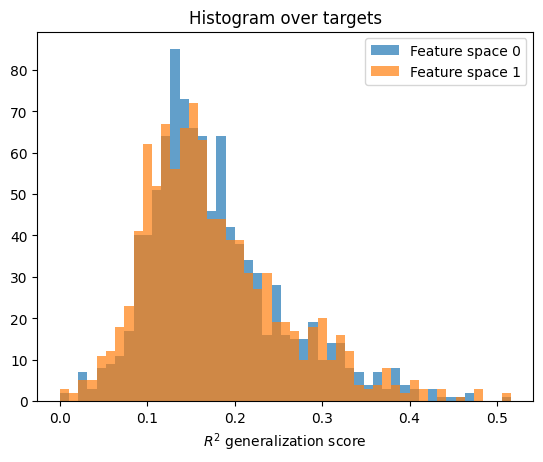

In [8]:
maximum = 0
for score in test_scores:
    maximum = max(maximum, score.max())

bins = np.linspace(0, maximum, 50)
for i, score in enumerate(test_scores):
    plt.hist(score, bins, alpha=0.7, label=f"{feature_names[i]}")

plt.xlabel(r"$R^2$ generalization score")
plt.title("Histogram over targets")
plt.legend()
plt.show()

## Joint model

In [9]:
X_train = np.hstack([X for X in Xs_train])
X_test = np.hstack([X for X in Xs_test])

### Prepare the pipeline

In [10]:
# Find the start and end of each feature space X in Xs
start_and_end = np.concatenate([[0], np.cumsum(n_features_list)])
slices = [
    slice(start, end)
    for start, end in zip(start_and_end[:-1], start_and_end[1:])
]

# Create a different ``Kernelizer`` for each feature space.
kernelizers = [("space %d" % ii, Kernelizer(), slice_)
               for ii, slice_ in enumerate(slices)]
column_kernelizer = ColumnKernelizer(kernelizers)

### Define the random-search model
We use very few iteration on purpose, to make the random search suboptimal,
and refine it with hyperparameter gradient descent.



In [11]:
solver_params = dict(n_iter=5, alphas=np.logspace(-10, 10, 41))

model_random = MultipleKernelRidgeCV(kernels="precomputed", solver="random_search",
                                     solver_params=solver_params, random_state=42)
pipe_random = make_pipeline(column_kernelizer, model_random)

# Fit the model on all targets
pipe_random.fit(X_train, Y_train)


........................................] 100% | 6.89 sec | 5 random sampling with cv | 

Pipeline(steps=[('columnkernelizer',
                 ColumnKernelizer(transformers=[('space 0', Kernelizer(),
                                                 slice(np.int64(0), np.int64(1000), None)),
                                                ('space 1', Kernelizer(),
                                                 slice(np.int64(1000), np.int64(2000), None))])),
                ('multiplekernelridgecv',
                 MultipleKernelRidgeCV(kernels='precomputed', random_state=42,
                                       solver_params={'alphas': array([1.00000000e-10, 3.16227766e-10, 1.000...
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03, 3.16227766e+03,
       1.00000000e+04, 3.16227766e+04, 1.00000000e+05, 3.16227766e+05,
       1.00000000e+06, 3.16227766e+06, 1.00000000e+07, 3.16227766e+07,
       1.00000000e+08, 3.16227766e+08, 1.00000000e+09, 3.16227766e+09,
       1.00000000e+10]),
                                                      'n_iter': 5}))])

### Define the gradient-descent model

In [12]:
solver_params = dict(max_iter=10, hyper_gradient_method="direct",
                     max_iter_inner_hyper=10,
                     initial_deltas="here_will_go_the_previous_deltas")

model_gradient = MultipleKernelRidgeCV(kernels="precomputed", solver="hyper_gradient",
                                       solver_params=solver_params)
pipe_gradient = make_pipeline(column_kernelizer, model_gradient)

### Use the random-search to initialize the gradient-descent

In [13]:
# We might want to refine only the best predicting targets, since the
# hyperparameter gradient descent is less efficient over many targets.
top = 100  # top 60%
best_cv_scores = backend.to_numpy(pipe_random[-1].cv_scores_.max(0))
mask = best_cv_scores > np.percentile(best_cv_scores, 100 - top)

deltas = pipe_random[-1].deltas_
# deltas = deltas[:, mask]

pipe_gradient[-1].solver_params['initial_deltas'] = deltas
# pipe_2.fit(X_train, Y_train[:, mask])
pipe_gradient.fit(X_train, Y_train)


........................................] 100% | 103.51 sec | hypergradient_direct | 

Pipeline(steps=[('columnkernelizer',
                 ColumnKernelizer(transformers=[('space 0', Kernelizer(),
                                                 slice(np.int64(0), np.int64(1000), None)),
                                                ('space 1', Kernelizer(),
                                                 slice(np.int64(1000), np.int64(2000), None))])),
                ('multiplekernelridgecv',
                 MultipleKernelRidgeCV(kernels='precomputed',
                                       solver='hyper_gradient',
                                       solver_params={'hyper_gradient_method': 'direct',
                                                      'initial_deltas': array([[-3.0005355 , -4.1470246 ,  0.45334214, ..., -4.151828  ,
        -2.9957323 , -4.151828  ],
       [-2.990952  , -4.1470246 ,  0.46292555, ..., -4.142245  ,
        -2.9957323 , -4.142245  ]], dtype=float32),
                                                      'max_iter': 10,
                                                      'max_iter_inner_hyper': 10}))])

### Compute predictions on a test set

In [14]:
# use the first model for all targets
test_scores_random = pipe_random.score(X_test, Y_test)

# use the second model for the refined targets
# test_scores_2 = backend.copy(test_scores_1)
# test_scores_2[mask] = pipe_2.score(X_test, Y_test[:, mask])
test_scores_refined = pipe_gradient.score(X_test, Y_test)

test_scores_random = backend.to_numpy(test_scores_random)
test_scores_refined = backend.to_numpy(test_scores_refined)

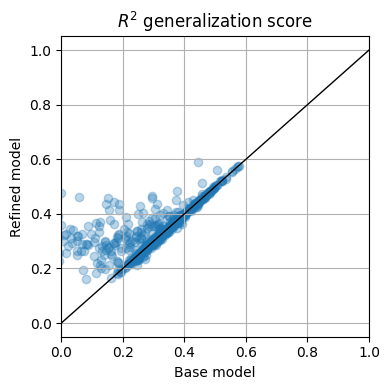

In [15]:
plt.figure(figsize=(4, 4))
plt.scatter(test_scores_random, test_scores_refined, alpha=0.3)
plt.xlim(0, 1)
plt.plot(plt.xlim(), plt.xlim(), color='k', lw=1)
plt.xlabel(r"Base model")
plt.ylabel(r"Refined model")
plt.title("$R^2$ generalization score")
plt.grid()
plt.tight_layout()
plt.show()

## Model comparison

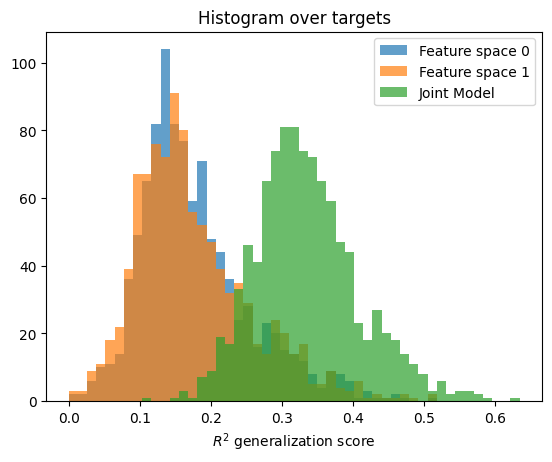

In [16]:
maximum = test_scores_refined.max()
for score in test_scores:
    maximum = max(maximum, score.max())

bins = np.linspace(0, maximum, 50)
for score, feature in zip(test_scores, feature_names):
    plt.hist(score, bins, alpha=0.7, label=feature)
plt.hist(test_scores_refined, bins, alpha=.7, label="Joint Model")

plt.xlabel(r"$R^2$ generalization score")
plt.title("Histogram over targets")
plt.legend()
plt.show()

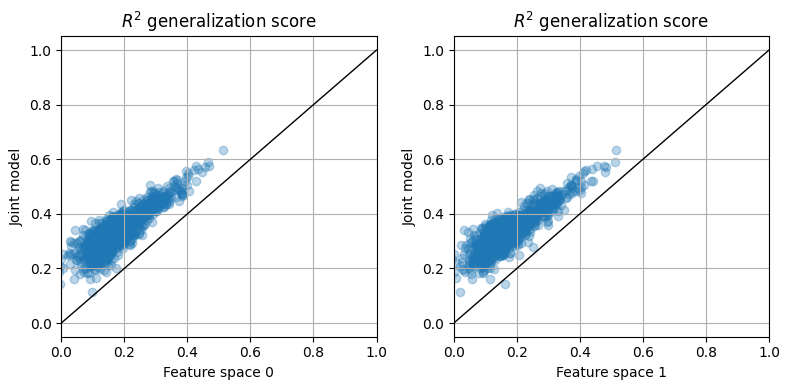

In [17]:
# Create a figure with subplots
fig, axs = plt.subplots(1, len(test_scores), figsize=(4 * len(test_scores), 4))

# Loop through each score and corresponding subplot
for i, score in enumerate(test_scores):
    ax = axs[i]
    ax.scatter(score, test_scores_refined, alpha=0.3)
    ax.set_xlim(0, 1)
    ax.plot(ax.get_xlim(), ax.get_xlim(), color='k', lw=1)
    ax.set_xlabel(f"{feature_names[i]}")
    ax.set_ylabel(r"Joint model")
    ax.set_title("$R^2$ generalization score")
    ax.grid()

# Adjust layout
plt.tight_layout()
plt.show()

## Variance partitioning

Create predictions

In [18]:
# single model predictions
corrs_single = []
for i, pipeline in enumerate(single_pipelines):
    prediction = pipeline.predict(Xs_test[i])

    correlation = backend.asarray([np.corrcoef(prediction[:, ii].ravel(), Y_test[:, ii])[0, 1]
                                   for ii in range(Y_test.shape[1])])
    correlation = backend.to_numpy(correlation)
    corrs_single.append(correlation)

prediction = pipe_gradient.predict(X_test)
corr_joint = backend.asarray([np.corrcoef(prediction[:, ii].ravel(), Y_test[:, ii])[0, 1]
                              for ii in range(Y_test.shape[1])])
corr_joint = backend.to_numpy(corr_joint)

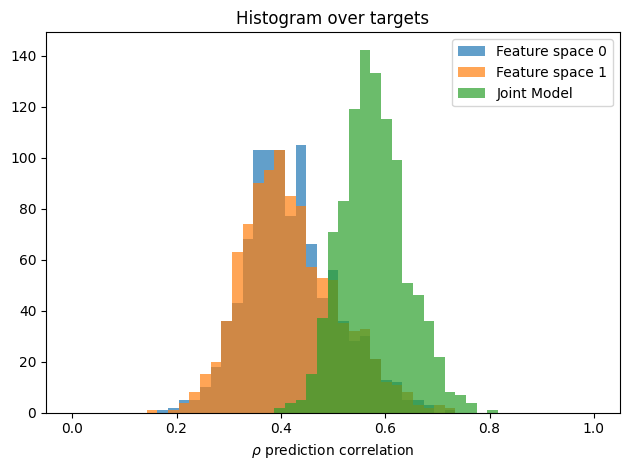

In [19]:
bins = np.linspace(0, 1, 50)

for corr, feature in zip(corrs_single, feature_names):
    plt.hist(corr, bins, alpha=.7, label=feature)

plt.hist(corr_joint, bins, alpha=.7, label="Joint Model")

plt.xlabel(r"$\rho$ prediction correlation")
plt.title("Histogram over targets")
plt.legend()
plt.tight_layout()
plt.show()

### Compute unique and shared variance using R^2

In [25]:
zero_minus_one = test_scores_refined - test_scores[1]
one_minus_zero = test_scores_refined - test_scores[0]

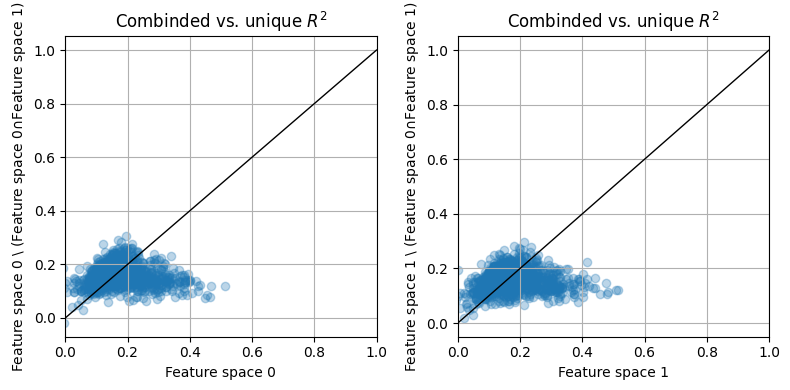

In [26]:
# Create a figure with subplots
fig, axs = plt.subplots(1, len(test_scores), figsize=(4 * len(test_scores), 4))

# Loop through each score and corresponding subplot
for i, (score, score_unique) in enumerate(zip(test_scores, [zero_minus_one, one_minus_zero])):
    ax = axs[i]
    ax.scatter(score, score_unique, alpha=0.3)
    ax.set_xlim(0, 1)
    ax.plot(ax.get_xlim(), ax.get_xlim(), color='k', lw=1)
    ax.set_xlabel(f"{feature_names[i]}")
    ax.set_ylabel(f"{feature_names[i]} \\ ({feature_names[0]}$\cap${feature_names[1]})")
    ax.set_title(r"Combinded vs. unique $R^2$")
    ax.grid()

# Adjust layout
plt.tight_layout()
plt.show()

### compute unique and shared variance using correlation

In [21]:
def ssc(data: np.array):
    """
    Calculate the signed squared correlation of a matrix
    :param data: np.array
    :return: np.array
    """
    # return data ** 2
    return (data ** 2) * np.sign(data)

In [22]:
# estimate the explained variance of each model using signed squared correlation
squared_intersection = ssc(corrs_single[0]) + ssc(corrs_single[1]) - ssc(corr_joint)
squared_variance_a_minus_b = ssc(corrs_single[0]) - squared_intersection
squared_variance_b_minus_a = ssc(corrs_single[1]) - squared_intersection

# take roots of the squared values
intersection = np.sqrt(squared_intersection)
variance_a_minus_b = np.sqrt(squared_variance_a_minus_b)
variance_b_minus_a = np.sqrt(squared_variance_b_minus_a)

# remove nans
variance_a_minus_b = np.nan_to_num(variance_a_minus_b)
variance_b_minus_a = np.nan_to_num(variance_b_minus_a)

/tmp/ipykernel_740674/696832362.py:7: RuntimeWarning: invalid value encountered in sqrt
  intersection = np.sqrt(squared_intersection)


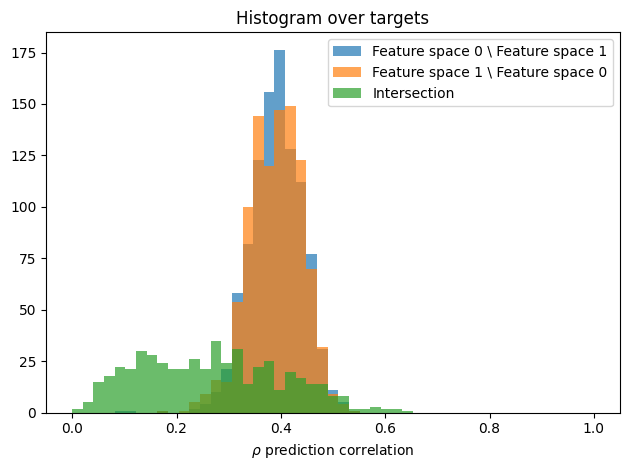

In [23]:
bins = np.linspace(0, 1, 50)

plt.hist(variance_a_minus_b, bins, alpha=.7, label="Feature space 0 \\ Feature space 1")
plt.hist(variance_b_minus_a, bins, alpha=.7, label="Feature space 1 \\ Feature space 0")
plt.hist(intersection, bins, alpha=.7, label="Intersection")

plt.xlabel(r"$\rho$ prediction correlation")
plt.title("Histogram over targets")
plt.legend()
plt.tight_layout()
plt.show()

#### Compare predictions before and after removing shared variance

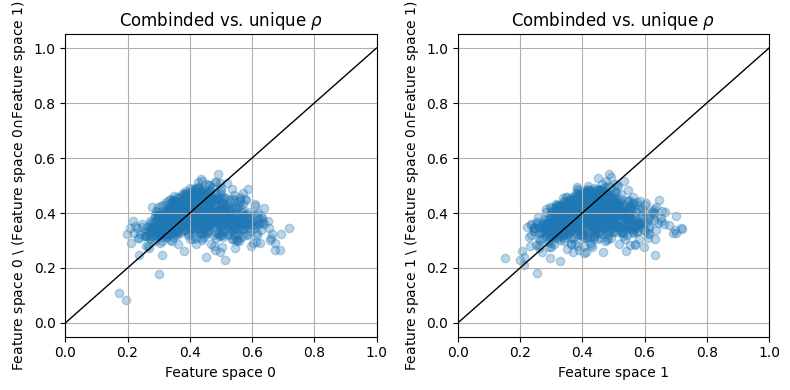

In [24]:
# Create a figure with subplots
fig, axs = plt.subplots(1, len(test_scores), figsize=(4 * len(test_scores), 4))

# Loop through each score and corresponding subplot
for i, (corr, corr_unique) in enumerate(zip(corrs_single, [variance_a_minus_b, variance_b_minus_a])):
    ax = axs[i]
    ax.scatter(corr, corr_unique, alpha=0.3)
    ax.set_xlim(0, 1)
    ax.plot(ax.get_xlim(), ax.get_xlim(), color='k', lw=1)
    ax.set_xlabel(f"{feature_names[i]}")
    ax.set_ylabel(f"{feature_names[i]} \\ ({feature_names[0]}$\cap${feature_names[1]})")
    ax.set_title(r"Combinded vs. unique $\rho$")
    ax.grid()

# Adjust layout
plt.tight_layout()
plt.show()